In [1]:
import pyvista as pv
import matplotlib
import numpy as np
from scipy.spatial.distance import cdist
from scipy.spatial import ConvexHull
from shapely import Polygon
from geopandas import GeoDataFrame
from multiview_mapping_toolkit.cameras.cameras import PhotogrammetryCameraSet
from multiview_mapping_toolkit.meshes.meshes import TexturedPhotogrammetryMesh
from scipy.spatial.transform import Rotation
from multiview_mapping_toolkit.config import MATPLOTLIB_PALLETE
from multiview_mapping_toolkit.config import VIS_FOLDER
from pathlib import Path

/ofo-share/repos-david/conda/envs/MVMT-dev/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Define utility functions

In [2]:
def create_non_overlapping_points(
    n_points, distance_thresh=1, size=10, random_seed=None
):
    np.random.seed(random_seed)
    all_points = (np.random.rand(1, 2) - 0.5) * size
    while all_points.shape[0] < n_points:
        new_point = (np.random.rand(1, 2) - 0.5) * size

        dist_from_existing = cdist(new_point, all_points)
        if np.min(dist_from_existing) > distance_thresh:
            all_points = np.concatenate((all_points, new_point), axis=0)

    return all_points

def extract_polygon(mesh: pv.PolyData):
    xy_points = mesh.points[:, :2]
    hull = ConvexHull(xy_points)
    return Polygon(xy_points[hull.vertices])


def make_color_gradient(color, number, hue_range=None):
    if hue_range is None:
        hue_range = 1 / (number * 2)

    hsv_color = matplotlib.colors.rgb_to_hsv(color)
    hue_start = hsv_color[0] - hue_range / 2
    hue_end = hsv_color[0] + hue_range / 2
    hues = np.linspace(hue_start, hue_end, number) % 1.0
    shifted_HSVs = [np.concatenate(([hue], hsv_color[1:]), axis=0) for hue in hues]
    rgb_values = [
        matplotlib.colors.hsv_to_rgb(shifted_hue) for shifted_hue in shifted_HSVs
    ]
    rgb_values = np.vstack(rgb_values)

    rgb_values = rgb_values / 255.0

    return rgb_values


def create_scene_mesh(
    box_centers=(),
    cylinder_centers=(),
    cone_centers=(),
    cylinder_radius=0.5,
    cone_radius=0.5,
    box_size=1 / np.sqrt(2.0),
    grid_size=(20, 20),
    add_ground=True,
):
    box_meshes = []
    box_polygons = []
    ID = 0.0
    for x, y in box_centers:
        x_min = x - box_size / 2.0
        x_max = x + box_size / 2.0
        y_min = y - box_size / 2.0
        y_max = y + box_size / 2.0

        box = pv.Box((x_min, x_max, y_min, y_max, 0, box_size), quads=False)
        box["ID"] = np.full(box.n_cells, fill_value=ID)
        box_meshes.append(box)
        box_polygons.append(extract_polygon(box))
        ID += 1.0

    cylinder_meshes = []
    cylinder_polygons = []
    for x, y in cylinder_centers:
        cylinder = pv.Cylinder(
            (x, y, 0.5), direction=(0, 0, 1), radius=cylinder_radius, resolution=10
        ).triangulate()
        cylinder["ID"] = np.full(cylinder.n_cells, fill_value=ID)
        cylinder_meshes.append(cylinder)
        cylinder_polygons.append(extract_polygon(cylinder))
        ID += 1.0

    cone_meshes = []
    cone_polygons = []
    for x, y in cone_centers:
        cone = pv.Cone(
            (x, y, 0.5),
            direction=(0, 0, -1),
            radius=cone_radius,
            resolution=12,
        ).triangulate()
        cone["ID"] = np.full(cone.n_cells, fill_value=ID)
        cone_meshes.append(cone)
        cone_polygons.append(extract_polygon(cone))
        ID += 1.0

    merged_mesh = pv.merge(box_meshes + cylinder_meshes + cone_meshes)
    labels_gdf = GeoDataFrame(
        {
            "name": ["cube"] * len(box_meshes)
            + ["cylinder"] * len(cylinder_meshes)
            + ["cone"] * len(cone_meshes)
        },
        geometry=box_polygons + cylinder_polygons + cone_polygons,
    )

    if add_ground:
        # Add the ground plane
        object_points = merged_mesh.points[np.isclose(merged_mesh.points[:, 2], 0)]
        grid_size_x, grid_size_y = grid_size
        # Add the corner points of the ground plane
        grid = np.meshgrid(
            np.linspace(-grid_size_x / 2, grid_size_x / 2, num=100),
            np.linspace(-grid_size_y / 2, grid_size_y / 2, num=100),
        )
        grid = [x.flatten() for x in grid]
        ground_points = np.vstack(grid + [np.zeros_like(grid[0])]).T

        ground_points = pv.PolyData(ground_points)
        object_points = pv.PolyData(object_points)
        combined = object_points + ground_points
        # Triangulate between all the vertices
        ground_surf = (combined).delaunay_2d()
        # Set the ID to nan
        ground_surf["ID"] = np.full(ground_surf.n_cells, fill_value=np.nan)
        # Merge the ground plane with the other actors
        merged_mesh = merged_mesh + ground_surf
    return merged_mesh, labels_gdf

# Define params

In [3]:
# Where to save content
CONCEPT_FIGURE_ROOT = Path(VIS_FOLDER, "concept_figure_content")

# Save vis or show them in the notebook
SAVE_VIS = False

# Number of map elements
N_BOXES = 5
N_CYLINDERS = 5
N_CONES = 5
# Random seed for object locations
MAP_RANDOM_SEED = 42

# Range of hues for each object
HUE_RANGE_DICT = {"cone": 0.1, "cylinder": 0.2, "cube": 0.1}
# Only used for realist
REALISTIC_COLOR_DICT = {
    "cone": MATPLOTLIB_PALLETE[0],
    "cylinder": MATPLOTLIB_PALLETE[2],
    "cube": MATPLOTLIB_PALLETE[1],
}

# Camera set params
CAM_HEIGHT = 10
CAM_DIST_FROM_CENTER = 10
CAM_PITCH = 135

CAM_INTRINSICS = {
    0: {"f": 4000, "cx": 0, "cy": 0, "image_width": 3000, "image_height": 2200}
}

# Create the example data

In [4]:
points = create_non_overlapping_points(n_points=(N_BOXES+N_CYLINDERS+N_CONES), random_seed=MAP_RANDOM_SEED)

mesh, labels_gdf = create_scene_mesh(
    box_centers=points[:N_BOXES],
    cylinder_centers=points[N_BOXES:(N_BOXES+N_CYLINDERS)],
    cone_centers=points[(N_BOXES+N_CYLINDERS):(N_BOXES+N_CYLINDERS+N_CONES)],
    add_ground=True,
)

# Define the colors for the "realistic" views

In [5]:

colors_per_face = np.full((mesh.n_cells, 3), fill_value=0.5)
IDs_per_face = np.full((mesh.n_cells, 1), fill_value=np.nan)

for i, (name, group) in enumerate(labels_gdf.groupby("name")):
    num = len(group)
    gradient = make_color_gradient(REALISTIC_COLOR_DICT[name], num, hue_range=HUE_RANGE_DICT[name])
    # Indices into the original dataset
    IDs = group.index.to_numpy()
    # TODO rename
    for ID, color in zip(IDs, gradient):
        matching = mesh["ID"] == ID
        colors_per_face[matching, :] = color
        IDs_per_face[matching, :] = i

# Show the 2D map

<Axes: >

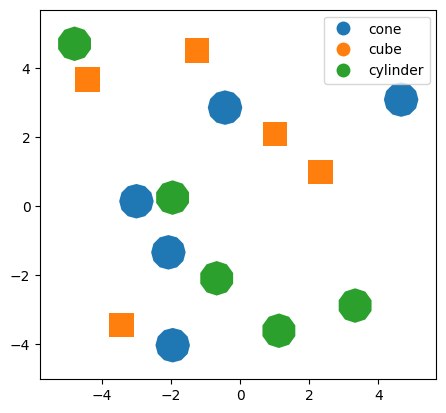

In [6]:
labels_gdf.plot("name", legend=True, cmap="tab10", vmin=0, vmax=9)


# Create a set of virtual cameras

In [7]:
t_vecs = (
    (0, 0, CAM_HEIGHT),
    (0, CAM_DIST_FROM_CENTER, CAM_HEIGHT),
    (CAM_DIST_FROM_CENTER, 0,  CAM_HEIGHT),
    (-CAM_DIST_FROM_CENTER, 0, CAM_HEIGHT),
    (0, -CAM_DIST_FROM_CENTER, CAM_HEIGHT),
)
# Roll, pitch, yaw convention
r_vecs = ((0, 180, 0), (0, CAM_PITCH, 0), (270, CAM_PITCH, 0), (90, CAM_PITCH, 0), (180, CAM_PITCH, 0))

cam_to_world_transforms = []
for r_vec, t_vec in zip(r_vecs, t_vecs):
    r_mat = Rotation.from_euler("ZXY", r_vec, degrees=True).as_matrix()
    transform = np.eye(4)
    transform[:3, :3] = r_mat
    transform[:3, 3] = t_vec
    cam_to_world_transforms.append(transform)

IMAGE_FOLDER = Path(CONCEPT_FIGURE_ROOT, "realistic_images")
IMAGE_FOLDER.mkdir(exist_ok=True, parents=True)

IMAGE_FILENAMES = [Path(IMAGE_FOLDER, f"img_{i:03d}.png") for i in range(5)]

camera_set = PhotogrammetryCameraSet(
    cam_to_world_transforms=cam_to_world_transforms,
    intrinsic_params_per_sensor_type=CAM_INTRINSICS,
    image_folder=IMAGE_FOLDER,
    image_filenames=IMAGE_FILENAMES
    
)

# Create a colored mesh with a "realistic" textuer

/ofo-share/repos-david/conda/envs/MVMT-dev/lib/python3.9/site-packages/pyvista/jupyter/notebook.py:33: UserWarning: Failed to use notebook backend: 

No module named 'trame.ui.vuetify'

Falling back to a static output.
  warnings.warn(


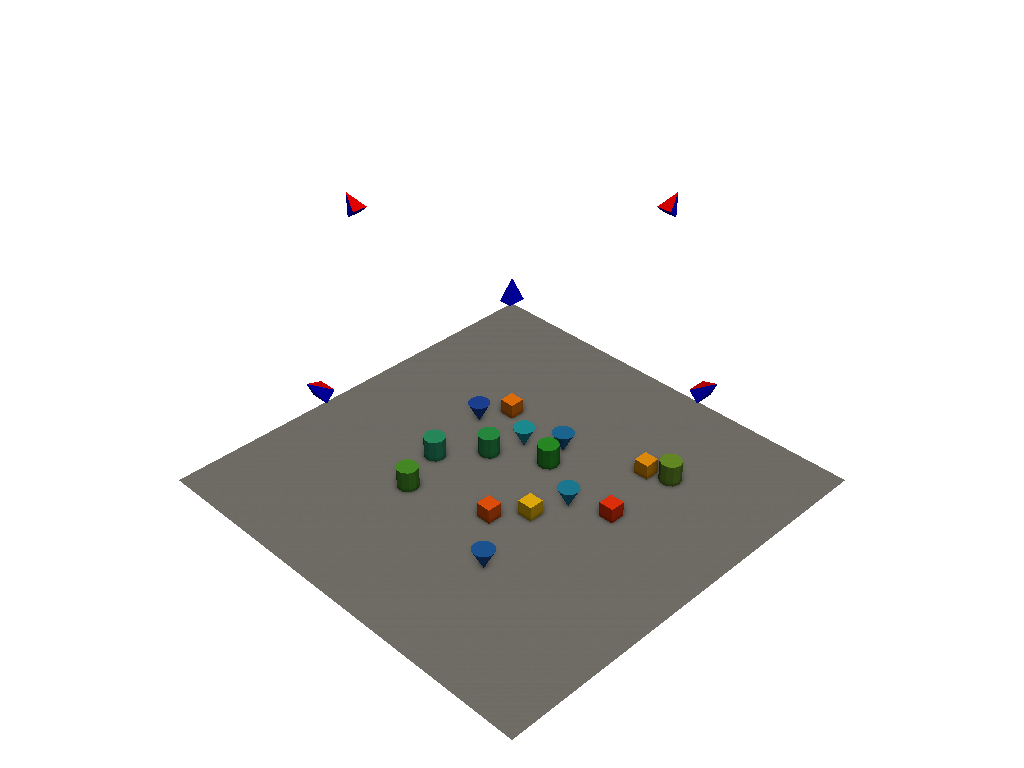

In [8]:
realistic_mesh = TexturedPhotogrammetryMesh(mesh, texture=colors_per_face)
realistic_mesh.vis(force_xvfb=True, camera_set=camera_set)

# Create a mesh textured with the labels

/ofo-share/repos-david/conda/envs/MVMT-dev/lib/python3.9/site-packages/pyvista/jupyter/notebook.py:33: UserWarning: Failed to use notebook backend: 

No module named 'trame.ui.vuetify'

Falling back to a static output.
  warnings.warn(


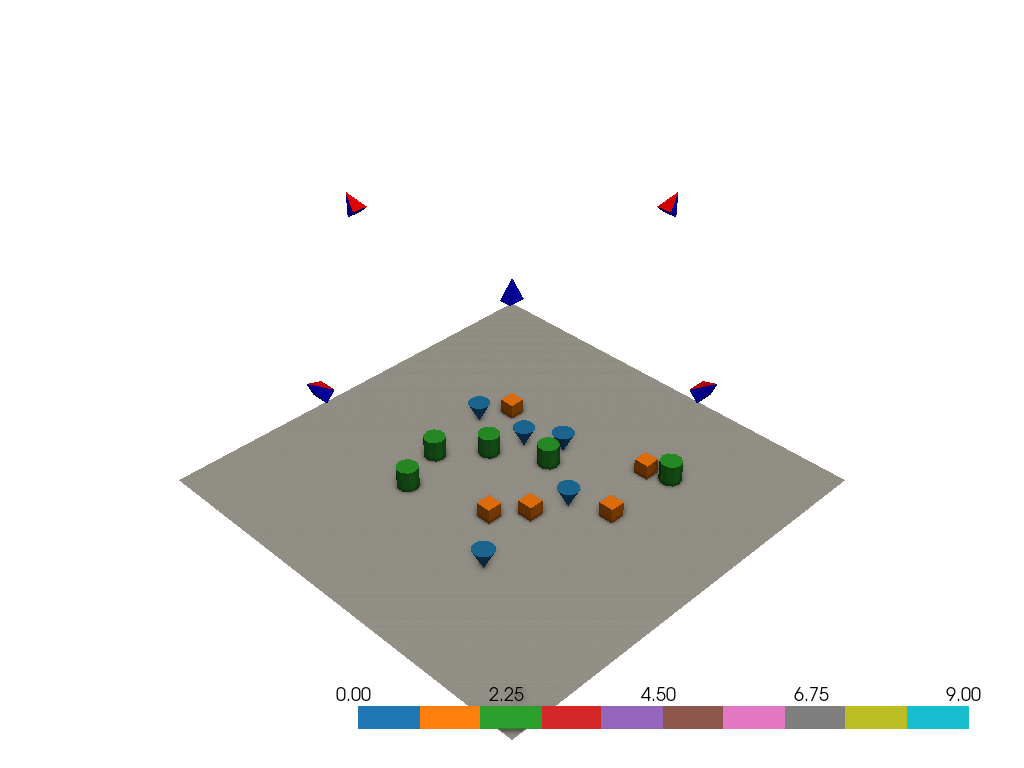

In [9]:
labeled_mesh = TexturedPhotogrammetryMesh(
    mesh, texture=IDs_per_face, texture_column_name="name"
)
labeled_mesh.vis(
    force_xvfb=True,
    camera_set=camera_set,
)

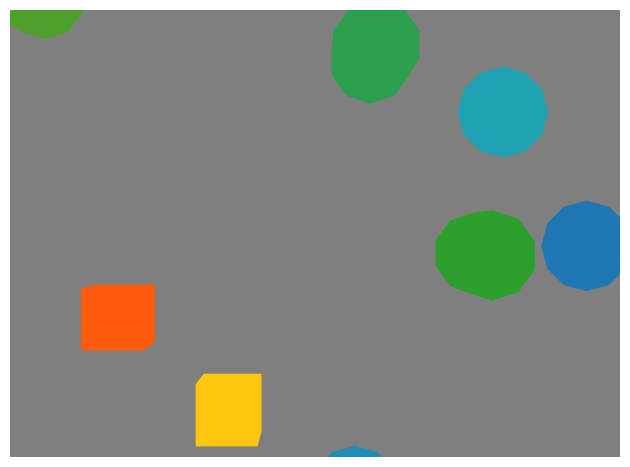

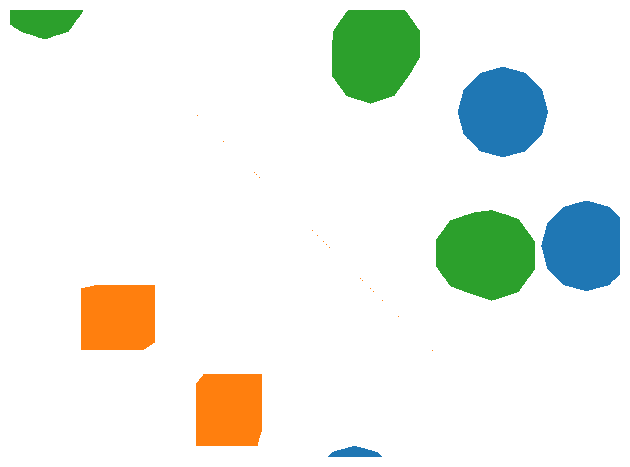

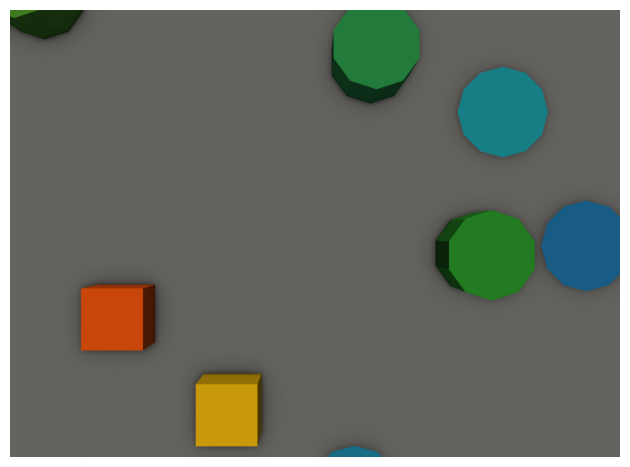

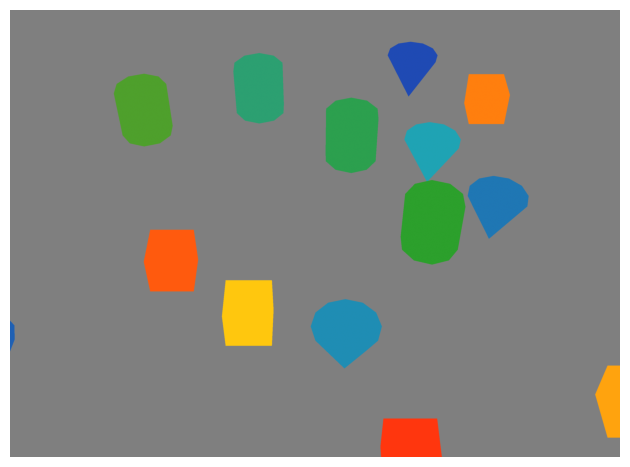

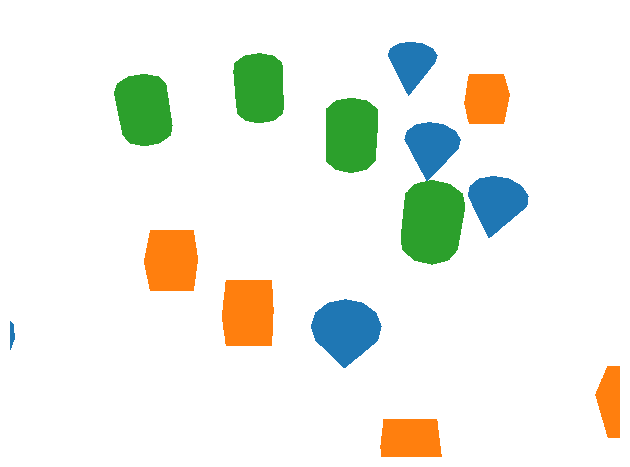

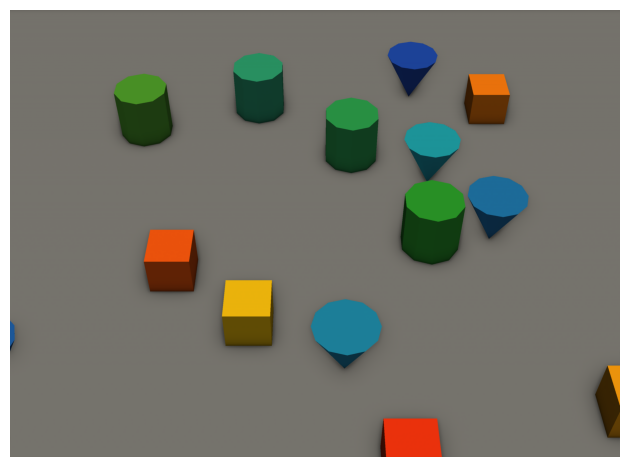

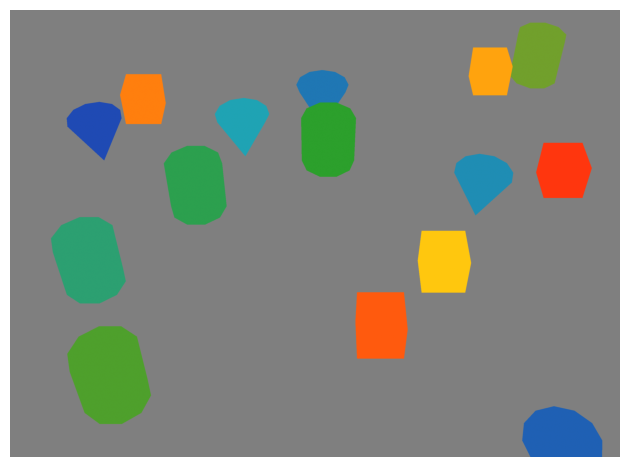

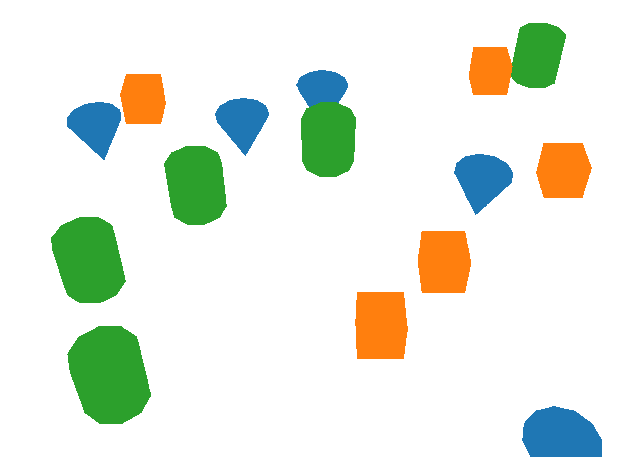

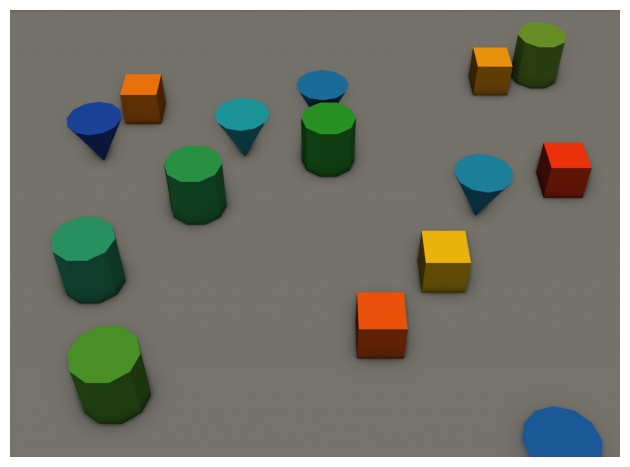

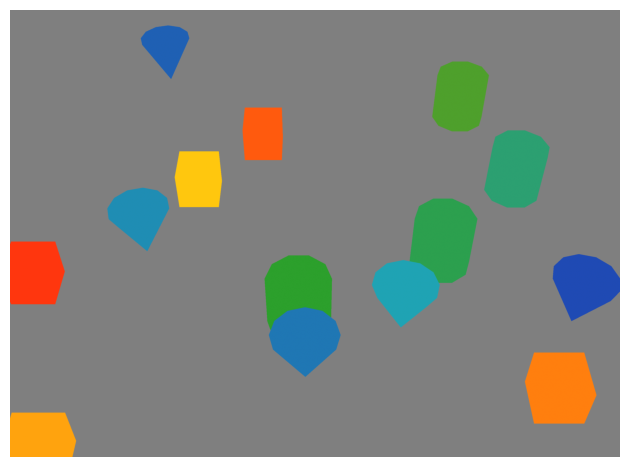

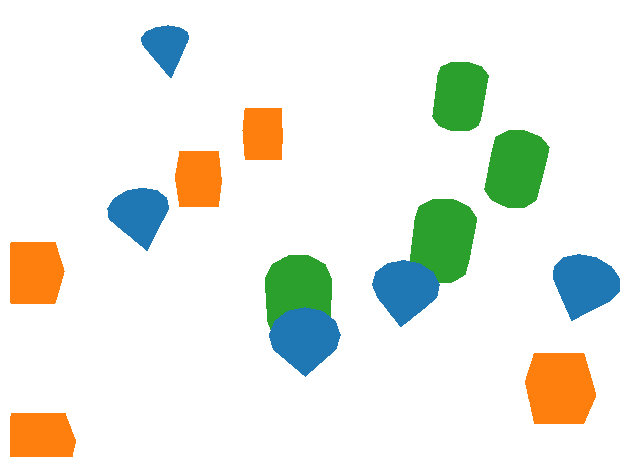

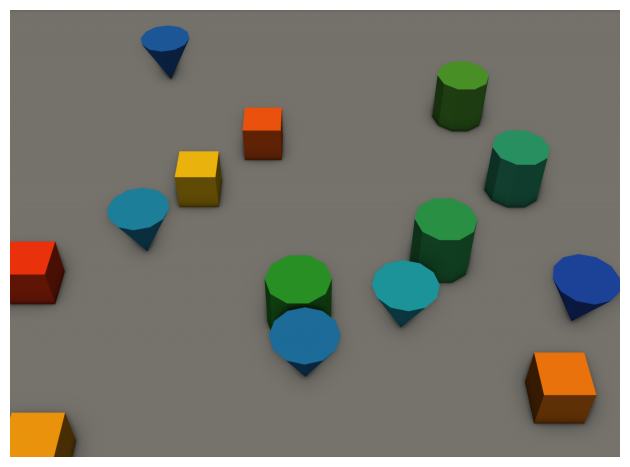

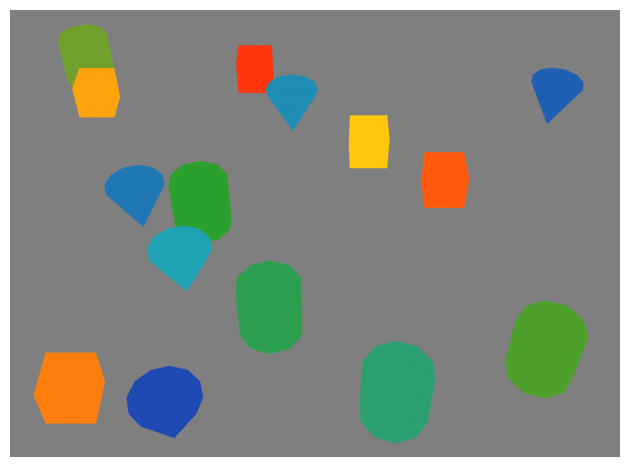

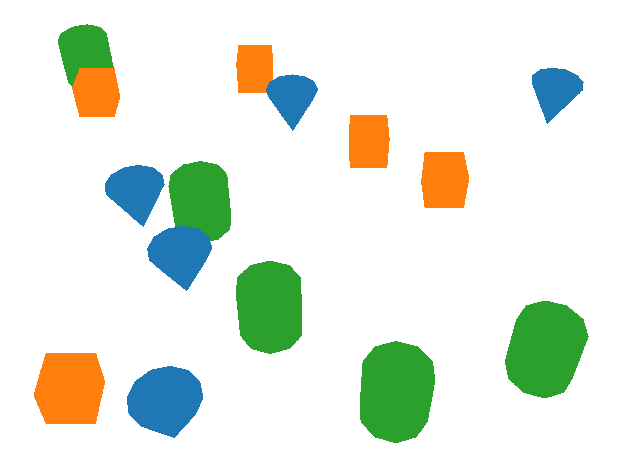

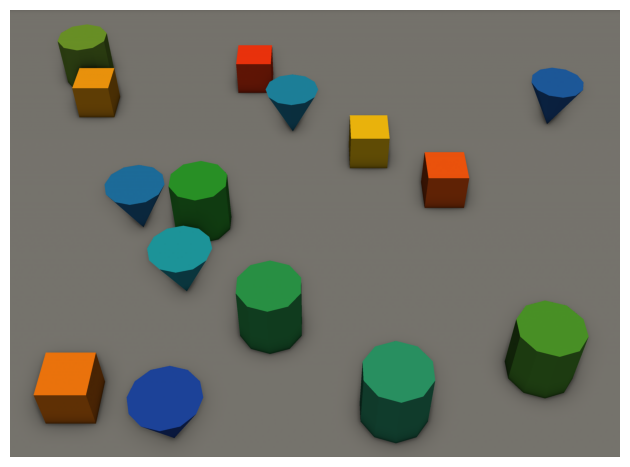

In [10]:
import matplotlib.pyplot as plt
from imageio import imwrite

FIGURE_SAVE_FOLDER = Path(CONCEPT_FIGURE_ROOT, "figures")
FIGURE_SAVE_FOLDER.mkdir(exist_ok=True, parents=True)

LABEL_IMAGES_FOLDER = Path(CONCEPT_FIGURE_ROOT, "labeled_images")
LABEL_IMAGES_FOLDER.mkdir(exist_ok=True, parents=True)

for i in range(5):
    # Do the three types of rendering
    label_render = labeled_mesh.render_pytorch3d(
        camera_set,
        i,
        shade_by_indexing=True,
    )
    flat_texture_render = realistic_mesh.render_pytorch3d(
        camera_set, i, shade_by_indexing=True
    )
    realistic_render = realistic_mesh.render_pyvista(camera_set, i, enable_ssao=True)
    
    # Save out an integer label image 
    label_render_for_saving = label_render.copy() 
    label_render_for_saving[np.logical_not(np.isfinite(label_render_for_saving))] = 255
    label_render_for_saving = label_render_for_saving.astype(np.uint8)
    imwrite(Path(LABEL_IMAGES_FOLDER,f"img_{i:03d}.png"), label_render_for_saving) 
    # Save out the rendered "realistic imager"
    image_path = camera_set.get_image_filename(i, absolute=True)
    imwrite(image_path, realistic_render)
    

    # Save or vis the figures 
    plt.axis("off")
    plt.tight_layout()
    plt.imshow(np.flip(flat_texture_render, (0, 1)))
    
    if SAVE_VIS:
        plt.savefig(f"../vis/concept_figures/texture_render_flat_{i:03d}.png")
        plt.close()
    else:
        plt.show()

    plt.axis("off")
    plt.tight_layout()
    plt.imshow(
        np.flip(label_render, (0, 1)),
        cmap="tab10",
        vmin=0,
        vmax=9,
        interpolation="none",
    )
    if SAVE_VIS:
        plt.savefig(f"../vis/concept_figures/class_render_flat{i:03d}.png")
        plt.close()
    else:
        plt.show()

    plt.axis("off")
    plt.tight_layout()
    plt.imshow(realistic_render)
    if SAVE_VIS:
        plt.savefig(f"../vis/concept_figures/texture_render_realistic_{i:03d}.png")
        plt.close()
    else:
        plt.show()

In [11]:
from multiview_mapping_toolkit.segmentation.derived_segmentors import LookUpSegmentor
from multiview_mapping_toolkit.segmentation.segmentor import SegmentorPhotogrammetryCameraSet

segmentor = LookUpSegmentor(IMAGE_FOLDER,LABEL_IMAGES_FOLDER, num_classes=3)
segmentor_camera_set = SegmentorPhotogrammetryCameraSet(camera_set, segmentor)
aggregation_mesh = TexturedPhotogrammetryMesh(mesh=mesh)

2023-12-22 17:23:26:rastervision.pipeline.rv_config: WARNING - Root temporary directory cannot be used: /opt/data/tmp. Using root: /tmp/tmpx_6bhssu


# Show counts

Aggregating information from different viewpoints: 100%|██████████| 1/1 [00:00<00:00,  1.61it/s]


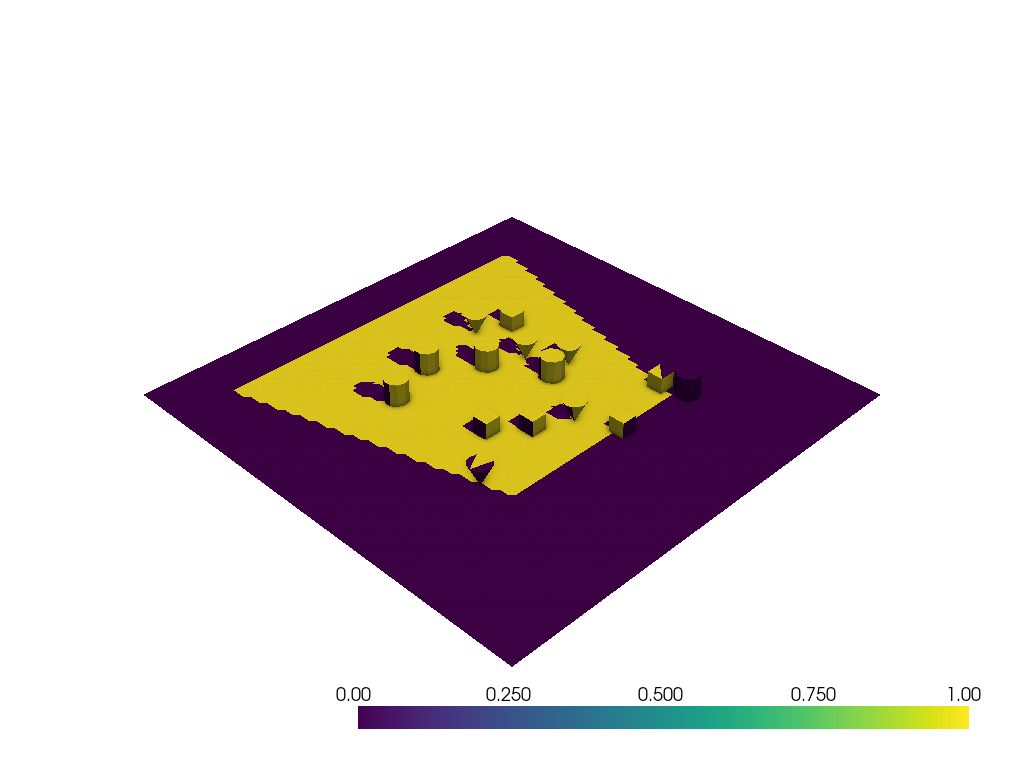

In [12]:
sub_camera_set = segmentor_camera_set.get_subset_cameras([1])
normalized_face_texture, face_texture, counts = aggregation_mesh.aggregate_viewpoints_pytorch3d(sub_camera_set)
aggregation_mesh.vis(vis_scalars=counts)

Aggregating information from different viewpoints: 100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


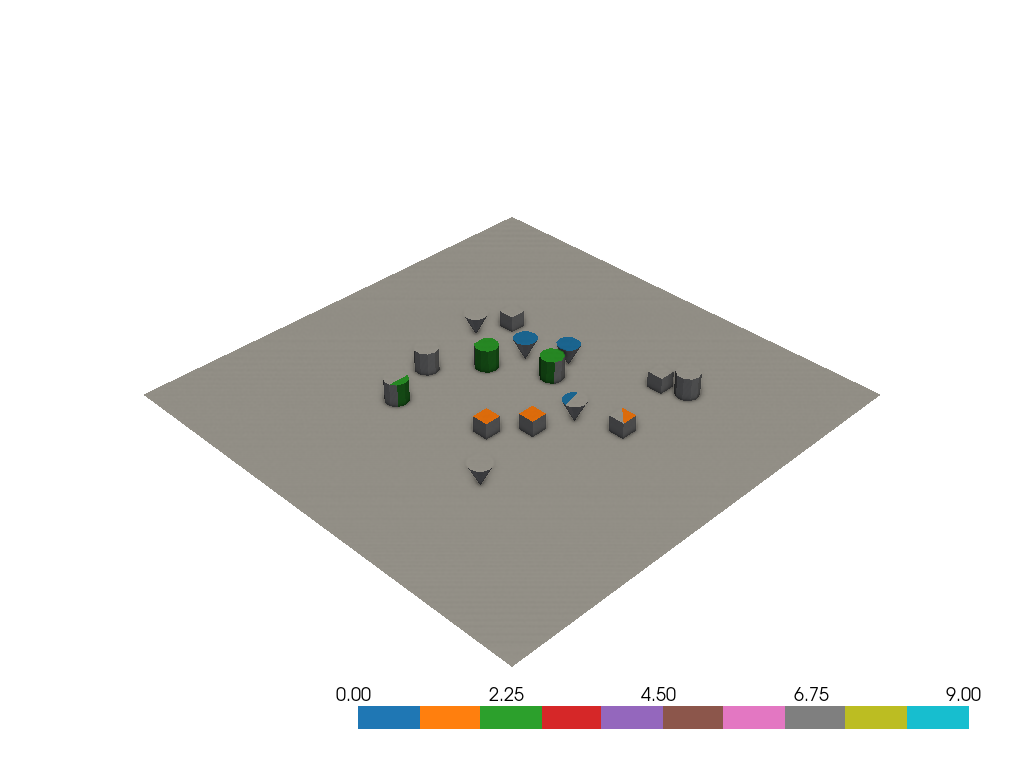

Aggregating information from different viewpoints: 100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


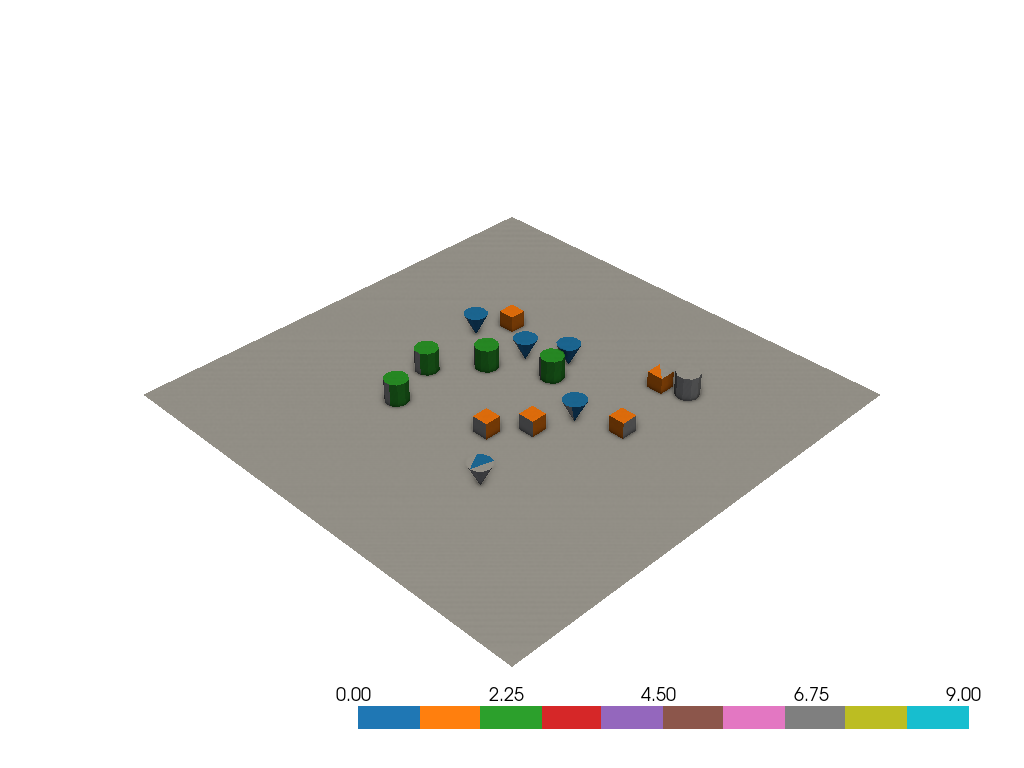

Aggregating information from different viewpoints: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]


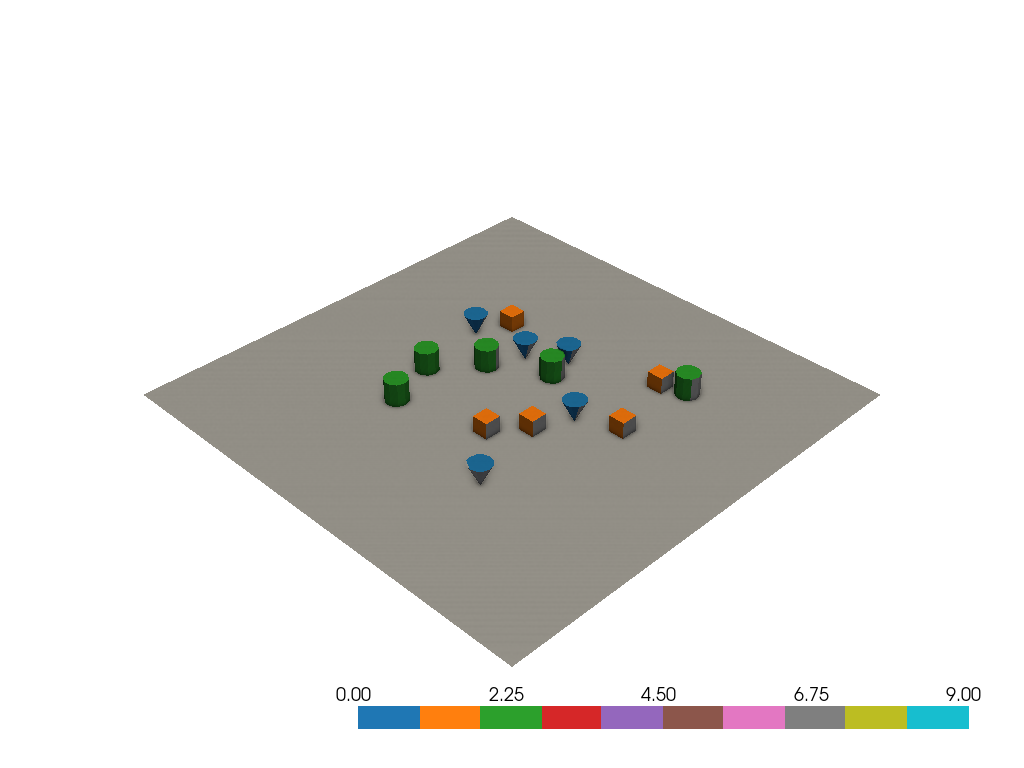

Aggregating information from different viewpoints: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


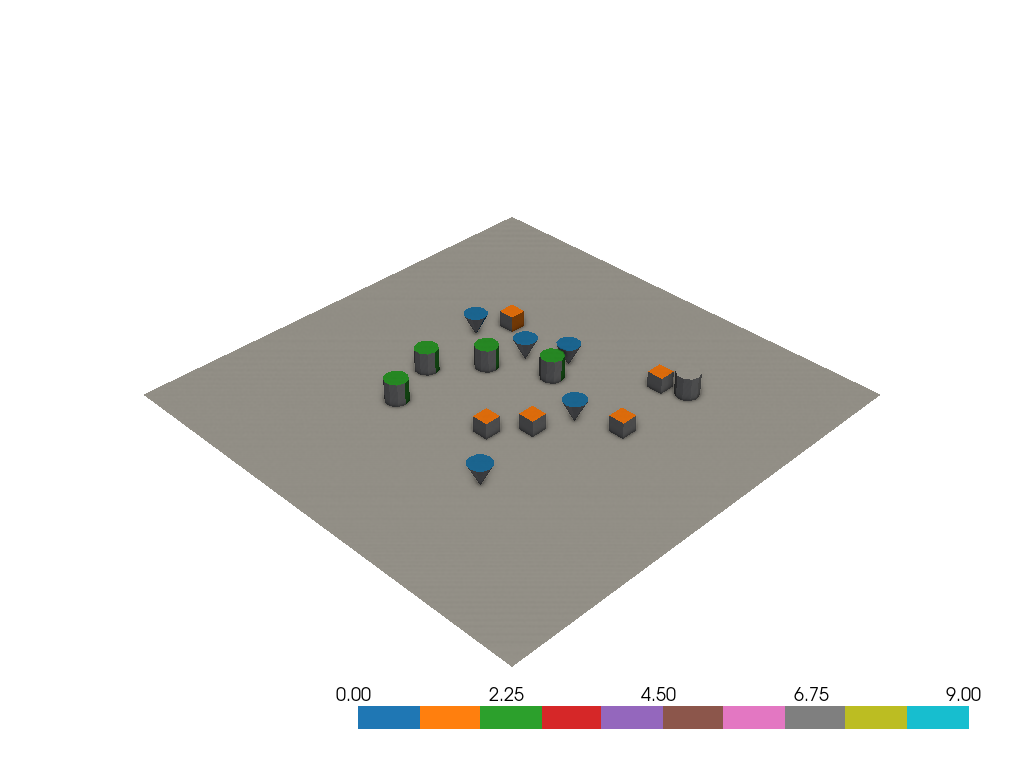

Aggregating information from different viewpoints: 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


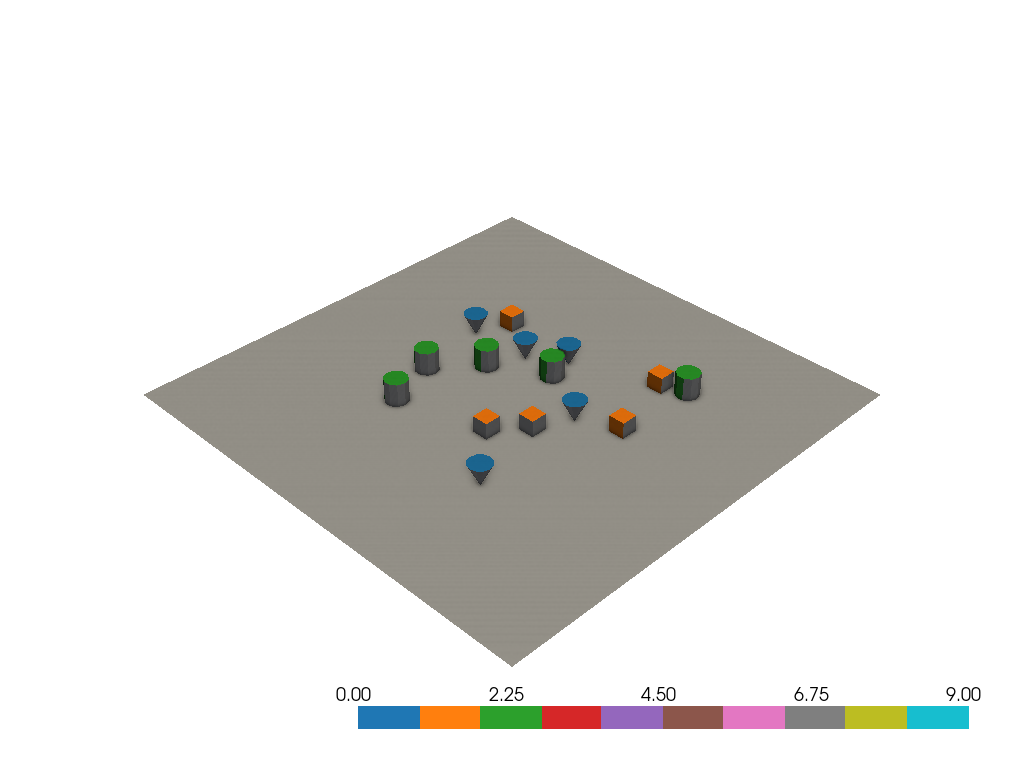

In [13]:
for i in range(5):
    sub_camera_set = segmentor_camera_set.get_subset_cameras([i])
    normalized_face_texture, face_texture, counts = aggregation_mesh.aggregate_viewpoints_pytorch3d(sub_camera_set)
    max_class = np.argmax(face_texture, axis=1).astype(float)
    zeros_mask = np.sum(face_texture, axis=1) == 0
    max_class[zeros_mask] = np.nan
    aggregation_mesh.vis(vis_scalars=max_class, force_xvfb=True, mesh_kwargs={"cmap":"tab10", "clim": (0,9)})

# Show aggregated viewpoint

Aggregating information from different viewpoints: 100%|██████████| 5/5 [00:03<00:00,  1.31it/s]


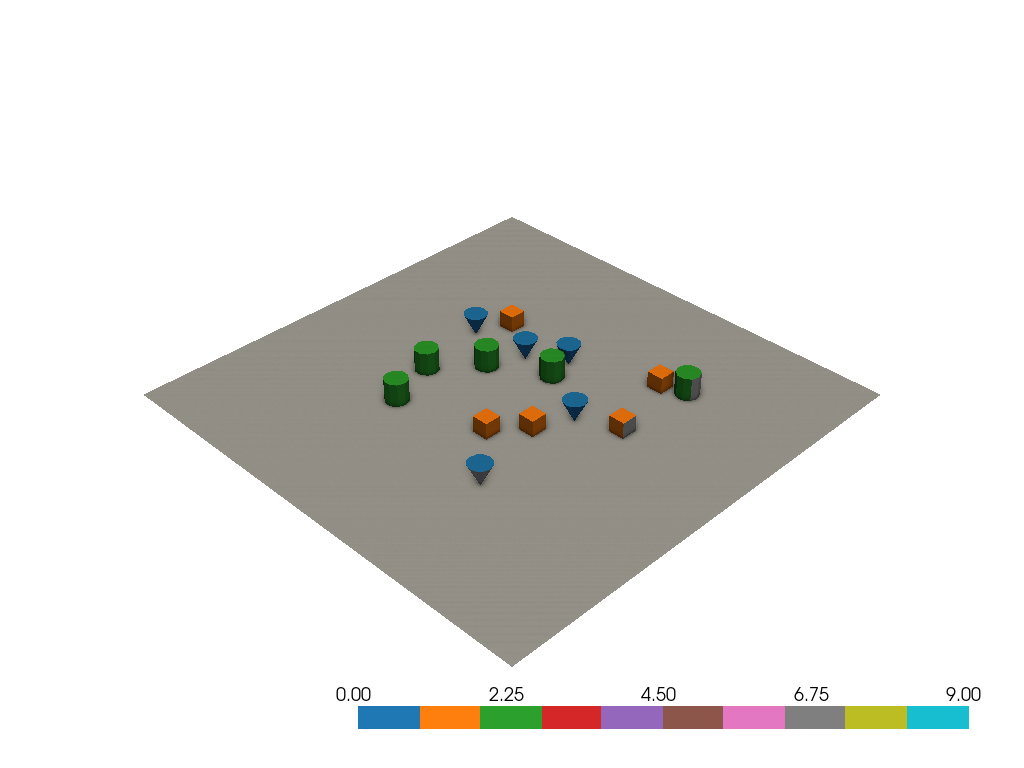

In [14]:
normalized_face_texture, face_texture, counts = aggregation_mesh.aggregate_viewpoints_pytorch3d(segmentor_camera_set)
max_class = np.argmax(face_texture, axis=1).astype(float)
zeros_mask = np.sum(face_texture, axis=1) == 0
max_class[zeros_mask] = np.nan
aggregation_mesh.vis(vis_scalars=max_class, force_xvfb=True, mesh_kwargs={"cmap":"tab10", "clim": (0,9)})